# Bibliotecas

In [44]:
# ! pip install xgboost
# ! pip install scikit-optimize

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     cross_val_score,
                                     RandomizedSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Dataset

## Treino e treino

In [46]:
treino = pd.read_csv('/content/drive/MyDrive/Datasets/Titanic/train.csv')

treino

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [47]:
treino.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

'Embarked' é variável categórica -> os valores NA serão subtituídos pela moda

'Age' é variável contínua -> os valores NA serão subtituídos pela média

In [48]:
treino['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [49]:
moda_embarked = treino['Embarked'].mode()[0]

treino.loc[treino['Embarked'].isnull(), 'Embarked'] = moda_embarked

treino['Embarked'].isnull().sum()

0

In [50]:
media_age = treino['Age'].mean()

treino.loc[treino['Age'].isnull(), 'Age'] = media_age

treino['Age'].isnull().sum()

0

In [51]:
X = treino.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis='columns') # Exclui features não interessantes

X['Sex'] = X['Sex'].map({'male': 0, 'female': 1}) # Sex variável discreta

X['Embarked'] = X['Embarked'].map({'C': 0, 'S': 1, 'Q': 2}) # Embarked variável discreta


y = treino['Survived']

In [52]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=12)

X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((623, 8), (268, 8), (623,), (268,))

## Teste_produção

In [53]:
teste_producao = pd.read_csv('/content/drive/MyDrive/Datasets/Titanic/test.csv')

teste_producao

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [54]:
teste_producao.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [55]:
teste_producao.loc[teste_producao['Age'].isnull(), 'Age'] = media_age

media_fare = treino['Fare'].mean()

teste_producao.loc[teste_producao['Fare'].isnull(), 'Fare'] = media_fare

teste_producao.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

O teste é como se fosse a produção, onde os dados não são conhecidos

Por essa razão os valores NA do teste foram substituídos pela moda Embarked e média Age do treino (dados conhecidos)

In [56]:
X_teste_producao = teste_producao.drop(['Name', 'Ticket', 'Cabin'], axis='columns') # Exclui features não interessantes

X_teste_producao['Sex'] = X_teste_producao['Sex'].map({'male': 0, 'female': 1}) # Sex variável discreta

X_teste_producao['Embarked'] = X_teste_producao['Embarked'].map({'C': 0, 'S': 1, 'Q': 2}) # Embarked variável discreta

In [57]:
X_teste_producao.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

# Modelo

In [58]:
cv = KFold(n_splits=10, random_state=12, shuffle=True) # Cross validation

clf = RandomForestClassifier(random_state=31) # Classificador

forest_rand_sem_tunning = cross_val_score(clf, X_treino, y_treino, scoring='accuracy', cv=cv, n_jobs=-1)

## Tunning randomizado

In [59]:
param_space = {'bootstrap': [True],
               'max_depth': [6, 8, 10, 12, 14],
               'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_leaf': [2, 3, 4],
               'min_samples_split': [2, 3, 4, 5],
               'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

forest_rand_search = RandomizedSearchCV(clf,
                                        param_space,
                                        n_iter=32,
                                        scoring='accuracy',
                                        cv=5,
                                        n_jobs=-1)

forest_rand_search.fit(X_treino, y_treino)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=31),
                   n_iter=32, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [6, 8, 10, 12, 14],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='accuracy')

In [60]:
forest_rand_search.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 14,
 'bootstrap': True}

In [61]:
forest_rand_search.best_estimator_

RandomForestClassifier(max_depth=14, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=600, random_state=31)

## Tunning bayesiano

In [62]:
search_space = {'bootstrap': Categorical([True, False]),
                'max_depth': Integer(6, 20),
                'max_features': Categorical(['auto', 'sqrt', 'log2']),
                'min_samples_leaf': Integer(2, 10),
                'min_samples_split': Integer(2, 10),
                'n_estimators': Integer(100, 500)}

forest_bayes_search = BayesSearchCV(clf,
                                    search_space,
                                    n_iter=32,
                                    scoring='accuracy',
                                    n_jobs=-1,
                                    cv=5)

forest_bayes_search.fit(X_treino, y_treino)

/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=31),
              n_iter=32, n_jobs=-1, scoring='accuracy',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'max_depth': Integer(low=6, high=20, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('auto', 'sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize')})

In [63]:
forest_bayes_search.best_params_

OrderedDict([('bootstrap', False),
             ('max_depth', 13),
             ('max_features', 'log2'),
             ('min_samples_leaf', 2),
             ('min_samples_split', 2),
             ('n_estimators', 483)])

In [64]:
forest_bayes_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=13, max_features='log2',
                       min_samples_leaf=2, n_estimators=483, random_state=31)

## XGBoost

In [65]:
clf = xgb.XGBClassifier()

# Cross validation apenas para comparação entre modelos
cv_xgboost_sem_tunning = cross_val_score(clf, X_treino, y_treino, scoring='accuracy')

## Tunnin XGBoost -> booster dart 

In [66]:
clf = xgb.XGBClassifier(max_depth=2,
                        booster='dart')

cv_xgboost_dart = cross_val_score(clf, X_treino, y_treino, scoring='accuracy')

## Tunnin XGBoost -> booster gbtree 

In [67]:
clf = xgb.XGBClassifier(max_depth=2,
                        booster='gbtree')

cv_xgboost_gbtree = cross_val_score(clf, X_treino, y_treino, scoring='accuracy')

## Tunnin XGBoost -> booster gblinear 

In [68]:
clf = xgb.XGBClassifier(max_depth=2,
                        booster='gblinear')

cv_xgboost_gblinear = cross_val_score(clf, X_treino, y_treino, scoring='accuracy')

# Comparativo de score

In [69]:
print('\n \
Random Forest sem tunning--------{:.2f} \n \
Random Forest randomizado--------{:.2f} \n \
Random Forest bayesiano----------{:.2f} \n \
XGBoost--------------------------{:.2f} \n \
XGBoost dart---------------------{:.2f} \n \
XGBoost gbtree-------------------{:.2f} \n \
XGBoost gblinear-----------------{:.2f}'.format(forest_rand_sem_tunning.mean(),
                                                forest_rand_search.best_score_,
                                                forest_bayes_search.best_score_,
                                                cv_xgboost_sem_tunning.mean(),
                                                cv_xgboost_dart.mean(),
                                                cv_xgboost_gbtree.mean(),
                                                cv_xgboost_gblinear.mean()))


 Random Forest sem tunning--------0.83 
 Random Forest randomizado--------0.85 
 Random Forest bayesiano----------0.86 
 XGBoost--------------------------0.83 
 XGBoost dart---------------------0.83 
 XGBoost gbtree-------------------0.83 
 XGBoost gblinear-----------------0.69


# Aplicação do melhor modelo

## Cross validation score

In [76]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Random Forest bayesiano
clf_melhor_modelo = RandomForestClassifier(bootstrap=False,
                                           max_depth=13,
                                           max_features='log2',
                                           min_samples_leaf=2,
                                           n_estimators=483,
                                           random_state=31)

In [82]:
scores_melhor_modelo = cross_val_score(clf_melhor_modelo, X_treino, y_treino, scoring='accuracy', cv=cv, n_jobs=-1)

media_scores_melhor_modelo = scores_melhor_modelo.mean()

print('Cross validation do melhor modelo----------{:.2f}'.format(media_scores_melhor_modelo))

Cross validation do melhor modelo----------0.85


## Predição de valores

In [83]:
clf_melhor_modelo.fit(X_treino, y_treino)

y_pred = clf_melhor_modelo.predict(X_teste)

In [84]:
y_pred.shape

(268,)

## Acurácia

In [105]:
acertos = (y_pred == y_teste).sum() # 214

tamanho_teste = len(y_teste) # 268

acc_melhor_modelo = acertos / tamanho_teste

round(acc_melhor_modelo, 3)

0.799

In [87]:
acc_melhor_modelo = accuracy_score(y_teste, y_pred)

print('Acurácia do melhor modelo----------{:.2f}'.format(acc_melhor_modelo))

Acurácia do melhor modelo----------0.80


In [116]:
scores_melhor_modelo_pred = cross_val_score(clf_melhor_modelo, X_teste, y_teste, scoring='accuracy', cv=cv, n_jobs=-1)

media_scores_melhor_modelo_pred = scores_melhor_modelo_pred.mean()

print('Cross validation do melhor modelo----------{:.2f}'.format(media_scores_melhor_modelo_pred))

Cross validation do melhor modelo----------0.77


In [207]:
df_pred = pd.DataFrame(data={'y_teste': y_teste,
                             'y_pred': y_pred})

df_pred.reset_index(drop=True, inplace=True)

df_pred

,y_teste,y_pred
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
...,...,...
263,0,0
264,0,0
265,1,0
266,0,0


## Análise gráfica

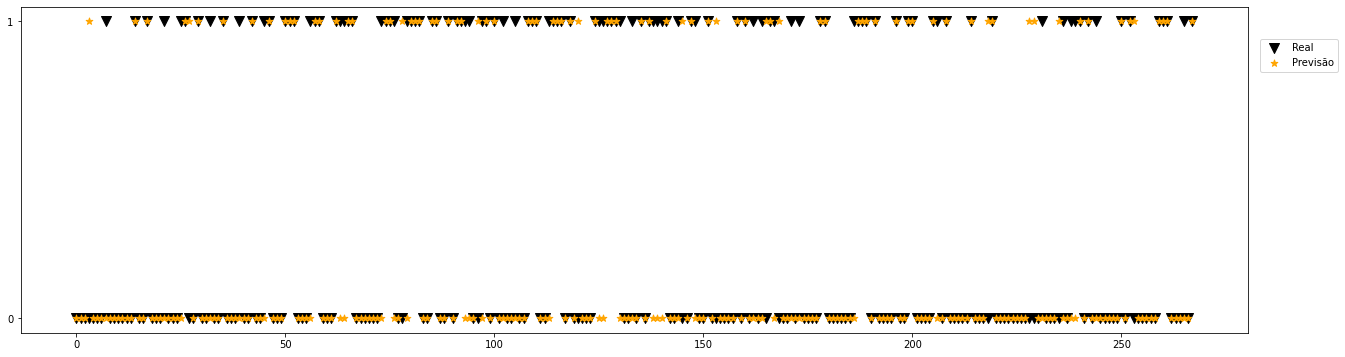

In [208]:
plt.figure(figsize=(22, 6))

plt.scatter(y=df_pred['y_teste'], x=df_pred.index, color='k', label='Real', s=100, marker='v')

plt.scatter(y=df_pred['y_pred'], x=df_pred.index, color='orange', label='Previsão', s=50, marker='*')

plt.yticks((0, 1))

plt.legend(loc=(1.01, 0.8))

# Previsão no teste_producao

In [209]:
y_pred_producao = clf_melhor_modelo.predict(X_teste_producao)

df_producao = X_teste_producao.copy()

df_producao['Pred_Survived'] = y_pred_producao

df_producao['Pred_Survived'].value_counts() # 0 = No, 1 = Yes

0    301
1    117
Name: Pred_Survived, dtype: int64

In [210]:
df_producao['Pred_Survived'] = df_producao['Pred_Survived'].map({0: 'no', 1: 'yes'})

df_producao

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Pred_Survived
0,892,3,0,34.500000,0,0,7.8292,2,no
1,893,3,1,47.000000,1,0,7.0000,1,no
2,894,2,0,62.000000,0,0,9.6875,2,no
3,895,3,0,27.000000,0,0,8.6625,1,no
4,896,3,1,22.000000,1,1,12.2875,1,no
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,29.699118,0,0,8.0500,1,no
414,1306,1,1,39.000000,0,0,108.9000,0,yes
415,1307,3,0,38.500000,0,0,7.2500,1,no
416,1308,3,0,29.699118,0,0,8.0500,1,no


## Cross validation

In [211]:
score_pred_producao = cross_val_score(clf_melhor_modelo, X_teste_producao, y_pred_producao, scoring='accuracy', cv=cv, n_jobs=-1)

media_score_pred_producao = score_pred_producao.mean()

print('Cross validation do melhor modelo----------{:.2f}'.format(media_scores_melhor_modelo_pred))

Cross validation do melhor modelo----------0.77
